In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "2"
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(os.environ["CUDA_VISIBLE_DEVICES"],torch.cuda.device_count(), torch.cuda.current_device())

2 1 0


In [2]:
import torch
import torchvision
from torchvision import transforms, datasets
import torch.nn as nn
from torch.nn import init
import torch.nn.functional as F
from torch import optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import glob
import os
from mpl_toolkits.axes_grid1 import make_axes_locatable
import time
import math

print(torch.__version__)
torch.cuda.is_available()

import h5py


1.12.0+cu102


## Data loading

In [3]:
from torchvision.transforms import ToTensor 
mnist_train_dataset = datasets.MNIST(
    root = 'data',
    train = True,                         
    transform = transforms.Compose([ToTensor(), transforms.Resize(32)]),
    download = True,            
)
mnist_test_dataset = datasets.MNIST(
    root = 'data', 
    train = False, 
    transform = transforms.Compose([ToTensor(), transforms.Resize(32)]),
)

In [4]:
train_data_loader = torch.utils.data.DataLoader(mnist_train_dataset, batch_size=32, shuffle=True)
val_data_loader = torch.utils.data.DataLoader(mnist_test_dataset, batch_size=32, shuffle=False)

Image batch shape: torch.Size([32, 1, 32, 32])
Labels batch shape: torch.Size([32])


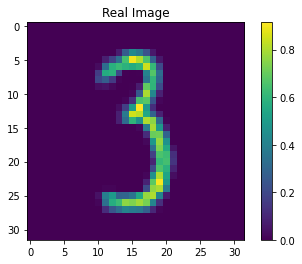

Minimum :0.0
Maximum :0.9143535494804382


In [5]:
digit_imgs,digit_labels   = next(iter(train_data_loader))

print(f"Image batch shape: {digit_imgs.size()}")
print(f"Labels batch shape: {digit_labels.size()}")
ind = 0
img = digit_imgs[ind].squeeze()
# label = train_labels[0]
plt.figure()
plt.imshow(img)
plt.title("Real Image")
plt.colorbar()
plt.show()
# print(f"Label: {label}")
print(f"Minimum :{img.min()}")
print(f"Maximum :{img.max()}")

## Model

In [14]:
class CNN_Encoder(nn.Module):
    
    def __init__(self, input_nc=1, ngf = 16):
        super(CNN_Encoder, self).__init__()
        self.enc1 = self.enc_block(in_ch = input_nc, out_ch = ngf, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        self.enc2 = self.enc_block(in_ch = ngf, out_ch = ngf*2, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        # self.enc3 = self.enc_block(in_ch = ngf*2, out_ch = ngf*4, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        # self.enc4 = self.enc_block(in_ch = ngf*4, out_ch = ngf*8, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        # self.enc5 = self.enc_block(in_ch = ngf*8, out_ch = ngf*16, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False  )
        
        
    def enc_block(self, in_ch, out_ch, kernel_size=4, stride=2, padding = 1,bias = True, innermost = False):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=kernel_size,stride=stride, padding=padding, bias=bias),
                # nn.ReLU()
                )
      
            
    def forward(self, x):
        x = self.enc1(x)
        x = self.enc2(x)
        # x = self.enc3(x)
        # x = self.enc4(x)
        # x = self.enc5(x)
        return x
    

class CNN_Decoder(nn.Module):
    
    def __init__(self, lat_chan=128,out_ch = 1, ngf = 16 ):
        super(CNN_Decoder, self).__init__()
        self.dec1 = self.conv_up_block(in_ch = lat_chan , out_ch = ngf*8, 
                                       kernel_size=4, stride=2, padding = 1,bias = True)
        self.dec2 = self.conv_up_block(in_ch = ngf*8 , out_ch = 1, 
                                       kernel_size=4, stride=2, padding = 1,bias = True)
        # self.dec3 = self.conv_up_block(in_ch = ngf*4 , out_ch = ngf*2, 
        #                                kernel_size=4, stride=2, padding = 1,bias = True)
        # self.dec4 = self.conv_up_block(in_ch = ngf*2 , out_ch = 1, 
        #                                kernel_size=4, stride=2, padding = 1,bias = True)
        # self.dec5 = self.conv_up_block(in_ch = ngf , out_ch = 1, 
                                       # kernel_size=4, stride=2, padding = 1,bias = True)
        # self.final = nn.Linear(16,out_ch)
        
        
    def conv_up_block(self,  in_ch, out_ch, kernel_size=4, stride=2, padding = 1,bias = True,outermost = False):
            return nn.Sequential(
                nn.ConvTranspose2d( in_ch, out_ch, kernel_size=kernel_size, stride=stride, padding = padding,bias = bias),
                # nn.ReLU()
                )
        
    def forward(self,x): 
        x = self.dec1(x)
        
        x = self.dec2(x)
        
        
#         x = self.dec3(x)
        
#         x = self.dec4(x)
        # x = self.dec5(x)
        # x = self.final(x)
        # x = torch.moveaxis(x,-1,1)
        return x

In [15]:
encoder = CNN_Encoder(ngf = 16).to(device)
decoder = CNN_Decoder(lat_chan=32).to(device)

lat_c = encoder(digit_imgs.to(device))
out = decoder(lat_c)
print(digit_imgs.shape,lat_c.shape,out.shape)

torch.Size([32, 1, 32, 32]) torch.Size([32, 32, 8, 8]) torch.Size([32, 1, 32, 32])


In [16]:
is_wandb = False
criterion = nn.L1Loss()
lr  = 0.001   
beta_1 = 0.9
beta_2 = 0.999
n_epochs = 100 
opt =  torch.optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), lr=lr, betas=(beta_1, beta_2))

In [17]:
def recon_loss(x_hat,x):
    criterion = nn.L1Loss()
    return criterion(x_hat,x)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count if self.count != 0 else 0

In [18]:
def train(encoder,decoder,opt,data_loader,is_wandb=False,verbose_freq = 500,is_verbose = False):
    encoder.train()
    decoder.train()
    
    batch_time = AverageMeter()
    data_time = AverageMeter()
    train_losses = AverageMeter()
    end = time.time()
    
    for batch_idx, (x,_ ) in enumerate(data_loader): 
        data_time.update(time.time() - end)
        
        opt.zero_grad()
        c_hat = encoder(x.to(device))
        x_hat = decoder(c_hat)
        
        loss = recon_loss(x_hat,x.to(device))
        
        loss.backward()
        opt.step()
        
        train_losses.update(loss.data.item())
        batch_time.update(time.time() - end)
        end = time.time()
        
        if is_verbose:
            if (batch_idx+1) % verbose_freq == 0:
                msg = 'Epoch: [{0}/{3}][{1}/{2}]\t' \
                      'Time {batch_time.val:.3f}s ({batch_time.avg:.3f}s)\t' \
                      'Speed {speed:.1f} samples/s\t' \
                      'Data {data_time.val:.3f}s ({data_time.avg:.3f}s)\t' \
                      'Loss {train_loss.val:.5f} ({train_loss.avg:.5f})\t'.format(
                          epoch_idx+1, batch_idx,len(data_loader), n_epochs , batch_time=batch_time,
                          speed=x.size(0)/batch_time.val,
                          data_time=data_time, train_loss=train_losses)
                print(msg)
        
        if is_wandb:
            wandb.log({"batch_loss": loss.data.item()})
    
    
    if is_wandb:
            wandb.log({"train_epoch_loss": train_losses.avg})
            wandb.log({"training time/Iter": batch_time.sum/len(data_loader)})
    
    
    # print(f"Evaluation   Epoch : {epoch_idx+1}  =====================>")
    if is_verbose:
        print(f"Training Epoch Loss: {train_losses.avg}")
    return train_losses.avg
        
        
def validate(encoder,decoder,data_loader,is_wandb=False,is_verbose = False):
    encoder.eval()
    decoder.eval()
    
    val_losses = AverageMeter()
    
    
    with torch.no_grad():
        for batch_idx, (x,_) in enumerate(data_loader): 
            c_hat = encoder(x.to(device))
            x_hat = decoder(c_hat)

            loss = recon_loss(x_hat,x.to(device)) 
            
            val_losses.update(loss.data.item())
    
    if is_wandb:
            wandb.log({"val_epoch_loss": val_losses.avg})
    
    
    # print(f"Evaluation   Epoch : {epoch_idx+1}  =====================>")
    if is_verbose:
        print(f"Val Epoch Loss: {val_losses.avg}")
    return val_losses.avg

In [19]:
exp_path = "./model_checkpoints/autoencoder_MNIST/"
if not os.path.exists(exp_path):
    os.mkdir(exp_path)

Training ====================================================================================================

Text(0.5, 1.0, 'Val Loss')

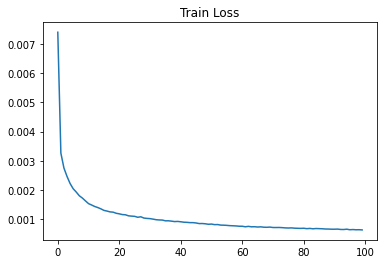

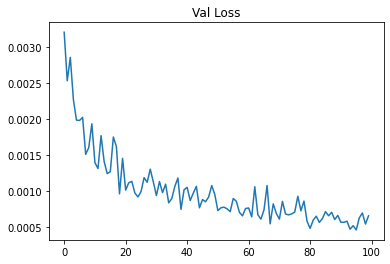

In [20]:
val_best_loss = 10000000
train_loss_list = []
val_loss_list = []

if not os.path.exists(exp_path):
    os.mkdir(exp_path)
print("Training ", end='')
for epoch_idx in range(n_epochs):
    print('=', end='')
    # print(f"Training Epoch : [{epoch_idx+1}/{n_epochs}]===============================================================================")
    
    train_loss = train(encoder,decoder,opt,train_data_loader)    
    val_losses = validate(encoder,decoder,val_data_loader) 

    train_loss_list.append(train_loss)
    val_loss_list.append(val_losses)
    if (val_losses < val_best_loss): 
        val_best_loss = val_losses
        # print("Saving Best Model =======================================>")
        torch.save(encoder, f'{exp_path}/encoder_2.pth.tar')
        torch.save(decoder, f'{exp_path}/decoder_2.pth.tar')
    
    
plt.figure()
plt.plot(train_loss_list)
plt.title("Train Loss")

plt.figure()
plt.plot(val_loss_list)
plt.title("Val Loss")

## Latent Space Visualization

In [26]:
from sklearn.manifold import TSNE

In [27]:
enc_path = f'{exp_path}/encoder_2.pth.tar'
encoder = torch.load(enc_path).to(device)
encoder.eval()
print(sum([np.prod(p.size()) for p in encoder.parameters()]))

8496


In [31]:
dec_path = f'{exp_path}/decoder_2.pth.tar'
decoder = torch.load(dec_path).to(device)
decoder.eval()
print(sum([np.prod(p.size()) for p in decoder.parameters()]))

67713


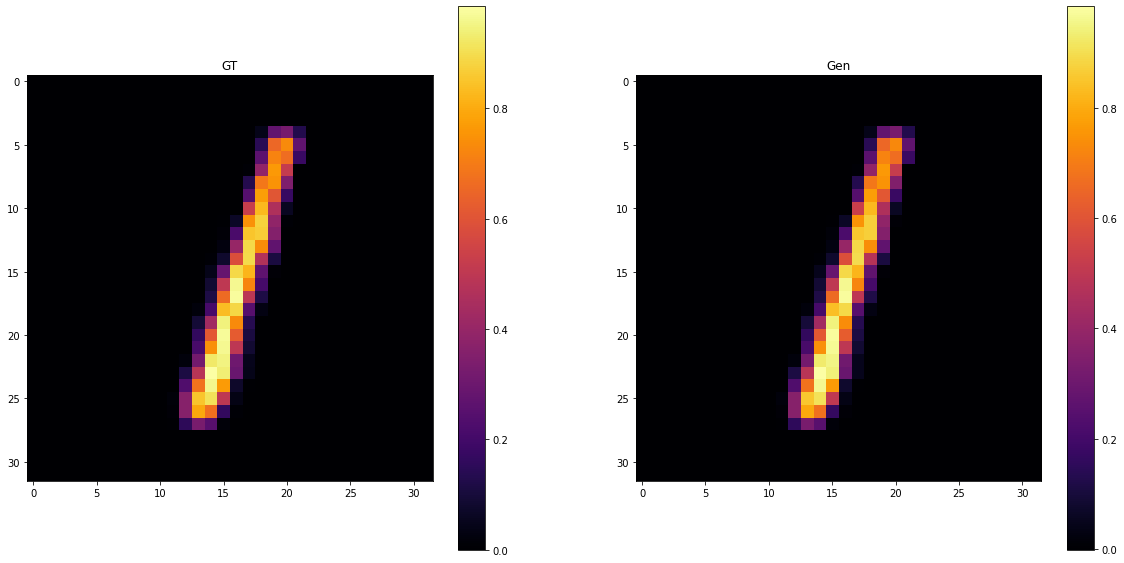

In [33]:
def plot_sub_plots(rows,columns,img_list,title_list,cmap = 'inferno'):
    fig, axs = plt.subplots(rows, columns, figsize = (columns*10,rows*10))
    if rows == 1:
        for i in range(len(img_list)):
            im1 = axs[i].imshow(img_list[i],cmap=cmap)
            axs[i].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i])#,shrink = 0.3
    else:
        for i in range(len(img_list)):
            im1 = axs[i//columns][i%columns].imshow(img_list[i],cmap=cmap)
            axs[i//columns][i%columns].set_title(f"{title_list[i]}")
            plt.colorbar(im1, ax=axs[i//columns][i%columns])#,shrink = 0.3)
    plt.show()
    # return fig

for batch_idx, (x,label) in enumerate(val_data_loader): 
    c_hat = encoder(x.to(device))
    x_hat = decoder(c_hat)
    break
    
    
plot_sub_plots(1,2,[x[2].detach().squeeze().cpu().numpy(),x_hat[2].detach().squeeze().cpu().numpy()],['GT','Gen'])

In [28]:
for batch_idx, (x,label) in enumerate(val_data_loader): 
    c_hat = encoder(x.to(device))
    if batch_idx==0:
        features = c_hat
        label_list = label
    else:
        features = torch.cat((features,c_hat),axis = 0)
        label_list = torch.cat((label_list,label),axis = 0)
print(features.shape,label_list.shape)

features = features.flatten(start_dim = 1).detach().cpu().numpy()
label_list = label_list.detach().cpu().numpy()

torch.Size([10000, 32, 8, 8]) torch.Size([10000])


In [29]:
tsne = TSNE(random_state = 42, n_components=2,verbose=0, perplexity=40, n_iter=300).fit_transform(features)

/home/jupyter-jathurshan/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/home/jupyter-jathurshan/.local/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,


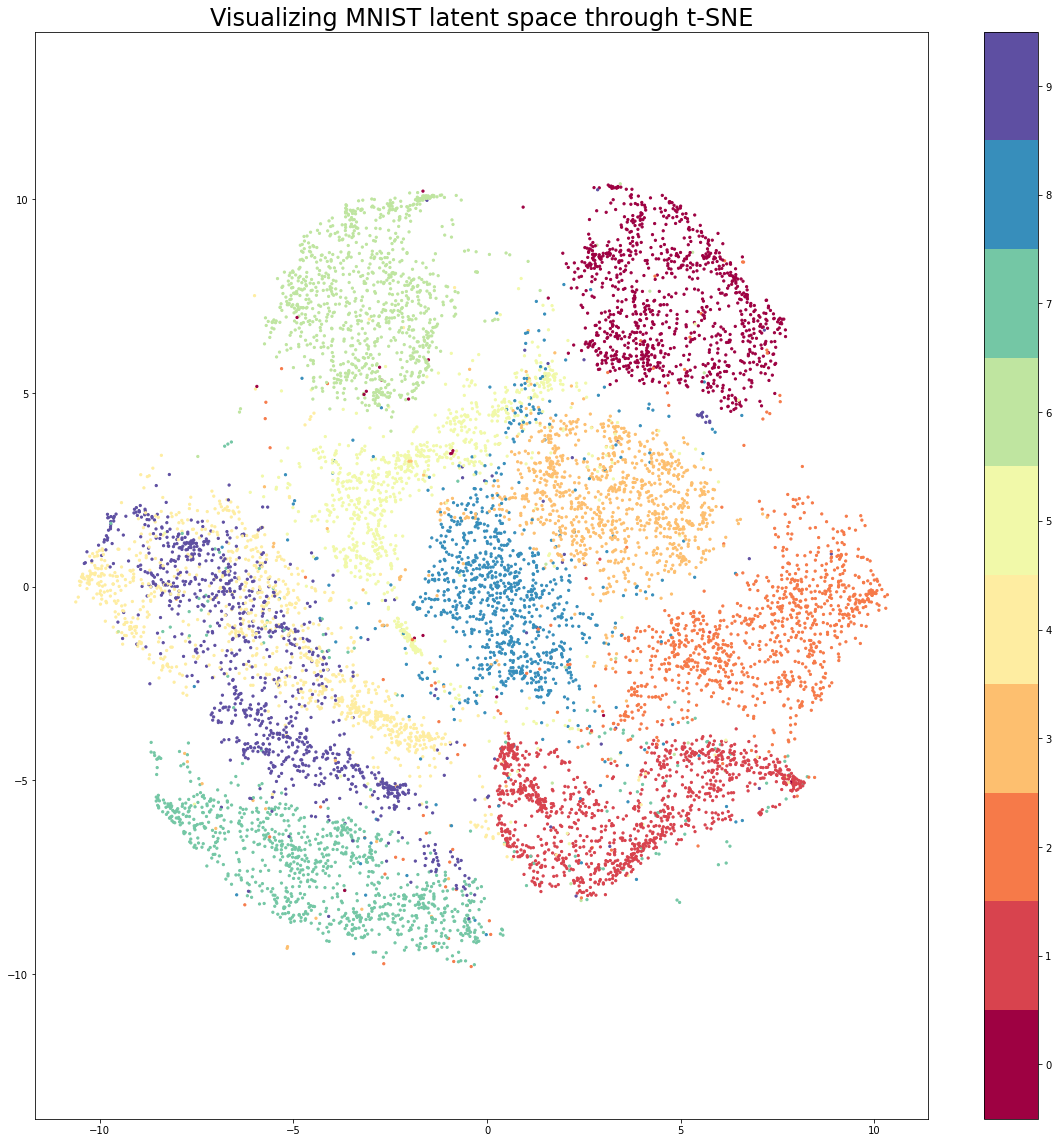

In [30]:
plt.figure(figsize = (20,20))
plt.scatter(tsne[:, 0], tsne[:, 1], s= 5, c=label_list, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Visualizing MNIST latent space through t-SNE', fontsize=24);